In [9]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from sklearn.impute import KNNImputer

plt.style.use('ggplot')
# %matplotlib.inline

In [6]:
df_control = pd.read_csv('control_group.csv', delimiter=';')

In [7]:
df_control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_control.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [14]:
df_control[df_control['Reach'].isna()]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


In [13]:
imputer = KNNImputer()
df_control.iloc[:,2:10]=pd.DataFrame(imputer.fit_transform(df_control.iloc[:,2:10]))

In [15]:
df_test = pd.read_csv('test_group.csv', delimiter=';')

In [16]:
df_test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [17]:
df_test.columns == df_control.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [21]:
df = pd.concat([df_control, df_test]).reset_index(drop = True)

In [42]:
df.columns = map(lambda x: x.strip('# of'), df.columns)

In [ ]:
#### Metrics we are inter

In [45]:
df['CTR'] = round(df['Website Clicks']/df['Impressions'], 2)
df['USD per Purchase'] = round(df['Spend [USD]']/df['Purchase'], 2)

### Data Visualization 

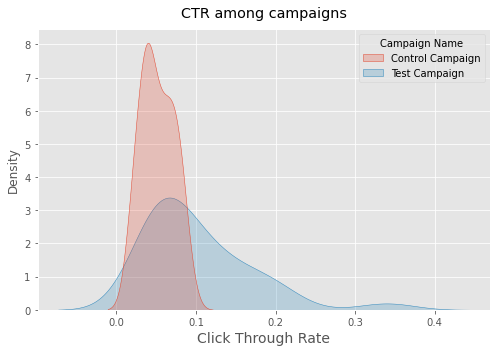

In [61]:
fig = plt.figure(figsize = (7, 5))
sns.kdeplot(x = 'CTR',
           hue = 'Campaign Name',
           data = df, shade = True)
plt.title('CTR among campaigns', pad = 12)
plt.xlabel('Click Through Rate', fontsize = 14)
plt.tight_layout()
plt.show()
plt.close()

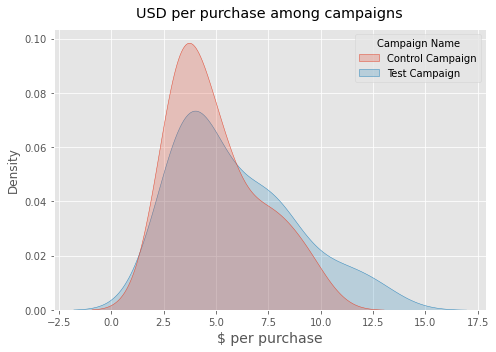

In [63]:
fig = plt.figure(figsize = (7, 5))
sns.kdeplot(x = 'USD per Purchase',
           hue = 'Campaign Name',
           data = df, shade = True)
plt.title('USD per purchase among campaigns', pad = 12)
plt.xlabel('$ per purchase', fontsize = 14)
plt.tight_layout()
plt.show()
plt.close()

### Hypothesis testing

$$H_0: \mu_{test} - \mu_{control} = 0$$
$$H_a: \mu_{test} - \mu_{control} \ne 0$$

In [66]:
test_g = df[df['Campaign Name'] == 'Test Campaign']
control_g = df[df['Campaign Name'] == 'Control Campaign']

In [102]:
test_CTR = round(test_g['CTR'].mean(), 3)
control_CTR = round(control_g['CTR'].mean(), 3)
uplift = (test_CTR - control_CTR)/control_CTR*100

print(f'Uplift is {uplift}%')

Uplift is 100.0%


#### Now let's test if this uplift is statistically significant. 

In [86]:
def two_t_test(control, test, alpha, col):
    mu_test = test[col].mean()
    mu_control = control[col].mean()
    
    sd_test = test[col].std()
    sd_control = control[col].std()
    
    mu = mu_test - mu_control
    sd = sd_test/len(test) + sd_control/len(control)
    
    z_val = mu/sd
    
    if z_val > st.norm.ppf(1-alpha/2):
        res = 'Reject'
    else:
        res = 'Fail to reject'
        
    p_val = 1 - st.norm.cdf(z_val)
    
    return p_val, z_val, res

In [87]:
p_val, z_score, result = two_t_test(control_g, test_g, 0.05, 'CTR')

In [92]:
print(f'Probability of observing such outcome or extreme is {p_val:.3}. Therefore we {result} the Null hypothesis')

Probability of observing such outcome or extreme is 0.0. Therefore we Reject the Null hypothesis


#### Now let's test if amount of purchase has changed during test

In [104]:
test_CTR = round(test_g['USD per Purchase'].mean(), 3)
control_CTR = round(control_g['USD per Purchase'].mean(), 3)
uplift = (test_CTR - control_CTR)/control_CTR*100

print(f'Uplift is {uplift:.3}%')

Uplift is 18.2%


In [105]:
p_val, z_score, result = two_t_test(control_g, test_g, 0.05, 'USD per Purchase')

In [106]:
print(f'Probability of observing such outcome or extreme is {p_val:.3}. Therefore we {result} the Null hypothesis')

Probability of observing such outcome or extreme is 1.37e-08. Therefore we Reject the Null hypothesis
